In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sp
import os as os
import multiprocessing
from joblib import Parallel, delayed
from time import time as ti
from skimage.restoration import denoise_wavelet
import pickle
#import CoreFunctions as cf
import sys
import random
import psutil

In [ ]:
DataFolder = '/sciclone/scr10/dchendrickson01/Recordings2/'
DataFolder = '/scratch/Recordings2/'

TIME_STEPS = 1200
Skips = 125
RollSize = 50

tic = ti()
start = tic

MemoryProtection = True

In [61]:
RunTwice = True

In [ ]:
FilesPerRun = 18
ConcurrentFiles = 6

In [3]:
def RollingStdDevFaster(RawData, SmoothData, RollSize = 25):

    Diffs = RawData - SmoothData
    del RawData, SmoothData
    
    Sqs = Diffs * Diffs
    del Diffs
    
    Sqs = Sqs.tolist() 
    Sqs.extend(np.zeros(RollSize))
    mSqs = np.matrix(Sqs)
    
    for i in range(RollSize):
        Sqs.insert(0, Sqs.pop())
        mSqs = np.concatenate((np.matrix(Sqs),mSqs))
    
    sVect = mSqs.sum(axis=0)
    eVect = (mSqs!=0).sum(axis=0)
    del mSqs, Sqs
    
    VarVect = sVect / eVect
    StdDevs = np.sqrt(VarVect)
    return np.asarray(StdDevs[:-RollSize].T)

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.02, verbose = False):
    
    SquelchSignal = np.ones(len(DataSet))
    if verbose:
        print(len(SquelchSignal))
        
    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+StallRange]) < SquelchLevel:
            SquelchSignal[i+StallRange]=0

    return SquelchSignal

def split_list_by_zeros(original_list, ones_list):
    # modified split_list_by_ones function to instead split by the zeros.
    #
    #
    # Created with Bing AI support
    #  1st request: "python split list into chunks based on value"
    #  2nd request: "I want to split the list based on the values in a second list.  Second list is all 1s and 0s.  I want all 0s removed, and each set of consequtive ones as its own item"
    #  3rd request: "That is close.  Here is an example of the two lists, and what I would want returned: original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
    #                ones_list =     [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
    #                return: [[1, 2, 3, 8], [4, 5, 6], [8,9]]"
    #
    #This is the function that was created and seems to work on the short lists, going to use for long lists
    
    result_sublists = []
    sublist = []

    for val, is_one in zip(original_list, ones_list):
        if not is_one:
            sublist.append(val)
        elif sublist:
            result_sublists.append(sublist)
            sublist = []

    # Add the last sublist (if any)
    if sublist:
        result_sublists.append(sublist)

    return result_sublists

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS, skips = Skips):
    output = []
    for i in range(int((len(values) - time_steps + skips)/skips)):
        output.append(values[i*skips : (i*skips + time_steps)])
    return np.stack(output)

In [4]:
def runFile(file, verbose = False, small = False, index=0, start=ti()):
    noise = verbose
    if file[-4:] == '.csv':    
        dataset = pd.read_csv(DataFolder+file, delimiter =",", header=None, engine='python',on_bad_lines='skip')
        if noise:
            print("File Read", ti()-start)
        dataset = dataset.rename(columns={0:"Day"})
        dataset = dataset.rename(columns={1:"Second"})
        dataset = dataset.rename(columns={2:"FracSec"})
        dataset = dataset.rename(columns={3:"p"})
        dataset = dataset.rename(columns={4:"h"})
        dataset = dataset.rename(columns={5:"v"})
        dataset = dataset.rename(columns={6:"Sensor"})

        dataset['Second'].replace('',0)
        dataset['FracSec'].replace('',0)
        dataset.replace([np.nan, np.inf, -np.inf],0,inplace=True)
        
        dataset[['Day','Second']] = dataset[['Day','Second']].apply(lambda x: x.astype(int).astype(str).str.zfill(6))
        dataset[['FracSec']] = dataset[['FracSec']].apply(lambda x: x.astype(int).astype(str).str.zfill(4))

        dataset["timestamp"] = pd.to_datetime(dataset.Day+dataset.Second+dataset.FracSec,format='%y%m%d%H%M%S%f')
        dataset["timestamps"] = dataset["timestamp"]

        dataset["p"] = dataset.p - np.average(dataset.p)
        dataset["h"] = dataset.h - np.average(dataset.h)
        dataset["v"] = dataset.v - np.average(dataset.v)
        dataset["r"] = np.sqrt(dataset.p**2 + dataset.h**2 + dataset.v**2)

        dataset.index = dataset.timestamp

        dataset["SmoothP"] = denoise_wavelet(dataset.p, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothH"] = denoise_wavelet(dataset.h, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothV"] = denoise_wavelet(dataset.v, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        dataset["SmoothR"] = denoise_wavelet(dataset.r, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')

        if noise:
            print("Data Cleaned", ti()-start, len(dataset.p))

        RawData = dataset.v
        SmoothData = dataset.SmoothV
        RollSize = 25

        Diffs = RawData - SmoothData

        Sqs = Diffs * Diffs

        Sqs = Sqs.tolist() 

        Sqs.extend(np.zeros(RollSize))

        mSqs = np.matrix(Sqs)

        for i in range(RollSize):
            Sqs.insert(0, Sqs.pop())
            mSqs = np.concatenate((np.matrix(Sqs),mSqs))

        sVect = mSqs.sum(axis=0)
        eVect = (mSqs!=0).sum(axis=0)

        VarVect = sVect / eVect

        StdDevs = np.sqrt(VarVect)

        StdDevsZ = np.asarray(StdDevs)

        StdDevsZ=np.append(StdDevsZ,[0])

        StdDevsZ = np.asarray(StdDevsZ.T[:len(dataset.p)])

        if noise:
            print("Size StdDevsZ", ti()-start, np.shape(StdDevsZ))

        #StdDevsZ = np.nan_to_num(StdDevsZ)

        #StdDevsZ[StdDevsZ == np.inf] = 0
        #StdDevsZ[StdDevsZ == -np.inf] = 0

        if noise:
            print("cleaned", ti()-start, np.shape(StdDevsZ))

        SmoothDevZ = denoise_wavelet(StdDevsZ, method='VisuShrink', mode='soft', wavelet='sym2', rescale_sigma='True')

        if noise:
            print("denoise 1", ti()-start, np.shape(StdDevsZ))

        #SmoothDevZa = cf.Smoothing(StdDevsZ, 3, wvt='sym2', dets_to_remove=2, levels=3)
        #SmoothDevZ = np.ravel(SmoothDevZ[0,:])

        #SmoothDevZ = SmoothDevZ.tolist()

        if noise:
            print("denoise 2", ti()-start, np.shape(SmoothDevZ))

        #ataset["SmoothDevZ"] = SmoothDevZ

        SmoothDevZ[np.isnan(SmoothDevZ)]=0
        
        Max = np.max(SmoothDevZ)

        
        
        if noise:
            print("Max", ti()-start, np.shape(Max), Max)

        buckets = int(Max / 0.005) + 1
        bins = np.linspace(0,buckets*0.005,buckets+1)
        counts, bins = np.histogram(SmoothDevZ,bins=bins)

        CummCount = 0
        HalfWay = 0
        for i in range(len(counts)):
            CummCount += counts[i]
            if CummCount / len(SmoothDevZ) >= 0.5:
                if HalfWay == 0:
                    HalfWay = i

        SquelchLevel = bins[HalfWay] 
        if noise:
            print("SmoothDevz size", np.shape(SmoothDevZ))

        dataset["IsMoving"] = SquelchPattern(SmoothDevZ, 4000, SquelchLevel, verbose=noise)

        if noise:
            print("Squelch Made", ti()-start)
        #dataset["velocity"] = getVelocity(dataset.p, dataset.FracSec, dataset.IsMoving, 2)
        #if noise:
        #    print("Velocity Calculated.  File done: ",file)

        #df_pr = split_list_by_ones(dataset.p, dataset.IsMoving)
        #df_hr = split_list_by_ones(dataset.h, dataset.IsMoving)
        #df_vr = split_list_by_ones(dataset.v, dataset.IsMoving)
        #df_rrr = split_list_by_ones(dataset.r, dataset.IsMoving)
        df_ps = split_list_by_zeros(dataset.SmoothP, dataset.IsMoving)
        df_hs = split_list_by_zeros(dataset.SmoothH, dataset.IsMoving)
        df_vs = split_list_by_zeros(dataset.SmoothV, dataset.IsMoving)
        df_rs = split_list_by_zeros(dataset.SmoothR, dataset.IsMoving)

        MatsSmooth = []
        for i in range(len(df_ps)):
            MatsSmooth.append(np.vstack((df_ps[i],df_hs[i],df_vs[i],df_rs[i])))
        
        if verbose:
            print("Split by ones", ti()-start)


        '''df_p=[0]
        df_h=[0]
        df_v=[0]
        df_r=[0]
        df_rp=[0]
        df_rh=[0]
        df_rv=[0]
        df_rr=[0]
        for i in range(len(df_ps)):
            df_p += df_ps[i]
            df_h += df_hs[i]
            df_v += df_vs[i]
            df_r += df_rs[i]
            df_rp += df_pr[i]
            df_rh += df_hr[i]
            df_rv += df_vr[i]
            df_rr += df_rrr[i]
        '''
        if verbose:
            print('format changed', ti()-start, len(MatsSmooth))

        return MatsSmooth
    else:
        return ['fail','fail']
        
        #if verbose:
        #    print('Data normalized', ti()-start)

        #return df_p, df_h, df_v, df_r, df_rp, df_rh, df_rv, df_rr


In [5]:
files= os.listdir(DataFolder) 

In [6]:
random.shuffle(files)

In [7]:
%%time
#df_p, df_h, df_v, df_r, 
Mats = runFile(files[5], verbose = True, small = False, index=0, start=ti())

File Read 30.154534339904785
Data Cleaned 51.58132839202881 6492090
Size StdDevsZ 59.4977605342865 (6492090,)
cleaned 59.4978551864624 (6492090,)
denoise 1 59.64971947669983 (6492090,)
denoise 2 59.649765968322754 (6492090,)
Max 59.65419363975525 () 0.03711243584781681
SmoothDevz size (6492090,)
6492090
Squelch Made 89.11680316925049
Split by ones 92.36804294586182
format changed 92.36813020706177 972
CPU times: user 1min 26s, sys: 5.65 s, total: 1min 32s
Wall time: 1min 32s


In [8]:
def runWrapper(file, verbose = True, small = False, index=0, start=ti()):
    try:
        rtrn = runFile(file, verbose, small, index, start)
        return rtrn
    except:
        return np.zeros((10,10,3))

In [9]:
%%time
AllDatas = Parallel(n_jobs=ConcurrentFiles)(delayed(runWrapper)(files[(i+8)*7], False, False, 0, ti()) for i in range(FilesPerRun))

CPU times: user 552 ms, sys: 1.89 s, total: 2.44 s
Wall time: 14min 44s


In [10]:
for fileResponse in AllDatas:
    for Mat in fileResponse:
        Mats.append(Mat)

In [11]:
len(Mats)

5569

In [12]:
import CoreFunctions as cf

In [13]:
lengths = []
rejects = []
Keeps = []

In [14]:
for Mat in Mats:
    spm = np.shape(Mat)
    if len(spm) > 1:
        lenM = spm[1]
    else:
        lenM = 1
    if (lenM > 1250):
        lengths.append(lenM)
        Keeps.append(Mat)
    else:
        rejects.append(lenM)

In [15]:
if MemoryProtection:
    print('RAM memory % used:', psutil.virtual_memory()[2])
    del Mats, AllDatas


RAM memory % used: 8.1


In [16]:
len(lengths) / (len(lengths)+len(rejects))

0.37547135931046866

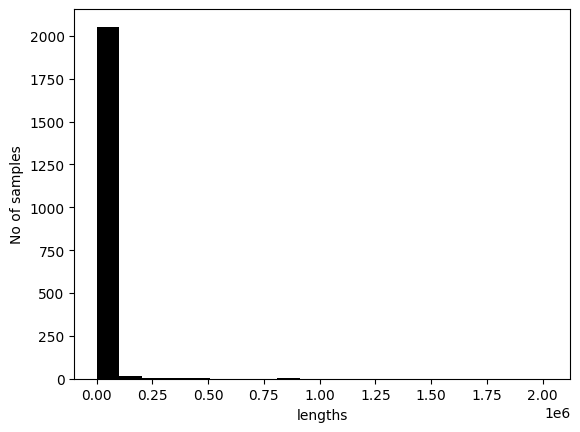

In [17]:
plt.hist(lengths, bins=20)
plt.xlabel("lengths")
plt.ylabel("No of samples")
plt.show()


In [18]:
Prints = []


In [19]:
np.shape(Keeps[3])

(4, 4854)

In [20]:
def PrintWrap(Mat):
    localPrints = []
    lenm = np.shape(Mat)[1]
    slices = int(lenm/TIME_STEPS)
    for i in range(slices):
        temp = (cf.makeMPFast(Mat[:3,i*TIME_STEPS:(i+1)*TIME_STEPS], wvt = 'sym4', scales = 60, spacer = 1, title = ''))
        localPrints.append(temp.astype(np.float32)/255.0)
    return localPrints

In [21]:
%%time
AllPrints = Parallel(n_jobs=8)(delayed(PrintWrap)(Mat) for Mat in Keeps)

CPU times: user 10.7 s, sys: 45.7 s, total: 56.4 s
Wall time: 1min 35s


In [22]:
if MemoryProtection:
    print('RAM memory % used:', psutil.virtual_memory()[2])
    del Keeps

RAM memory % used: 26.0


In [23]:
for group in AllPrints:
    for fprint in group:
        Prints.append(fprint)

for Mat in Keeps:
    lenm = np.shape(Mat)[1]
    slices = int(lenm/TIME_STEPS)
    for i in range(slices):
        temp = (cf.makeMPFast(Mat[:3,i*TIME_STEPS:(i+1)*TIME_STEPS], wvt = 'sym4', scales = 60, spacer = 1, title = ''))
        Prints.append(temp.astype(np.float32)/255.0)

In [24]:
if MemoryProtection:
    print('RAM memory % used:', psutil.virtual_memory()[2])
    del AllPrints


RAM memory % used: 25.9


np.shape(Prints)

In [25]:
len(Prints)

30780

In [26]:
np.max(Prints[1])

1.0

In [27]:
for i in range(7):
    print(np.shape(Prints[i*13]))

(60, 1200, 3)
(60, 1200, 3)
(60, 1200, 3)
(60, 1200, 3)
(60, 1200, 3)
(60, 1200, 3)
(60, 1200, 3)


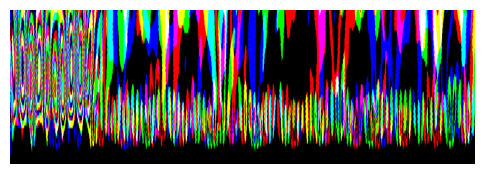

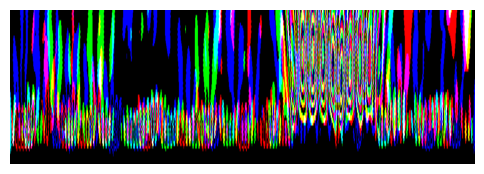

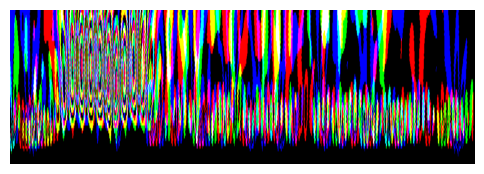

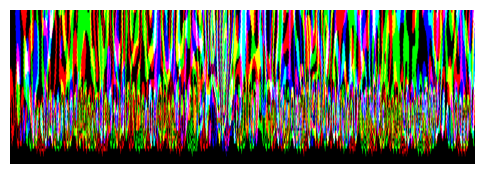

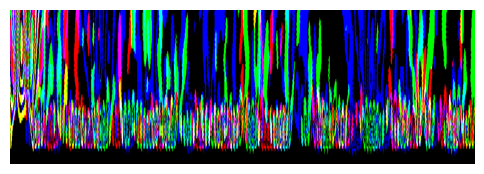

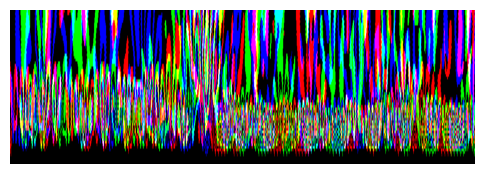

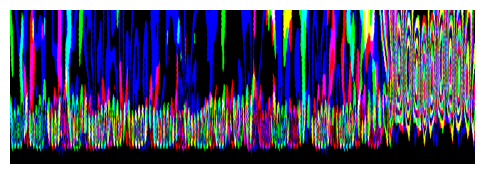

In [28]:
for i in range(7):
    fig = plt.figure(figsize=(6,2), dpi=100)
    plt.axis("off")
    plt.imshow(Prints[i*13], origin='lower',aspect='auto')
    plt.show()

# Start Machine Learning
## Using Autoencoder with Kears and Tensorflow
cite: https://pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/

In [29]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

2024-09-27 22:03:50.722856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 22:03:50.764171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 22:03:50.879188: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 22:03:50.915571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        inputShape = (height, width, depth)
        chanDim = -1
        inputs = Input(shape=inputShape)
        x = inputs

        for f in filters:
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        volumeSize = K.int_shape(x)
        print("Volume Size:", volumeSize)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)

        encoder = Model(inputs, latent, name="encoder")

        latentInputs = Input(shape=(latentDim,))
        flattenedVolumeSize = int(np.prod(volumeSize[1:]))
        print("Flattened Volume Size:", flattenedVolumeSize)
        x = Dense(flattenedVolumeSize)(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

        for f in filters[::-1]:
            x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)

        decoder = Model(latentInputs, outputs, name="decoder")
        autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

        return (encoder, decoder, autoencoder)


In [31]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
#from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
# construct the argument parse and parse the arguments


In [32]:
import random
import tensorflow as tf

In [33]:
from tensorflow.keras.callbacks import Callback

In [34]:
import keras

In [35]:
# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 32
TestSplit = 10 # 1/this many

# load the MNIST dataset

random.shuffle(Prints)

TestLength = int(len(Prints)/TestSplit)

In [36]:
np.shape(Prints)

(30780, 60, 1200, 3)

In [37]:
print(type(Prints))
print(Prints[0].dtype)
print(np.shape(Prints))
print('RAM memory % used:', psutil.virtual_memory()[2])

<class 'list'>
float32
(30780, 60, 1200, 3)
RAM memory % used: 26.0



# Assuming 'Prints' is your list

# Convert the list to a NumPy array with a consistent data type
try:
    prints_array = np.array(Prints, dtype=np.float32)
except Exception as e:
    print(f"Error converting to NumPy array: {e}")

# Check the shape and type of the NumPy array
print(f"Shape of prints_array: {prints_array.shape}")
print(f"Data type of prints_array: {prints_array.dtype}")

# Convert the NumPy array to a TensorFlow tensor
try:
    tensor_prints = tf.convert_to_tensor(prints_array)
    print(tensor_prints)
except Exception as e:
    print(f"Error converting to TensorFlow tensor: {e}")


In [38]:
for i, image in enumerate(Prints):
    if not isinstance(image, np.ndarray):
        Prints[i] = np.array(image, dtype=np.float32)
    elif image.dtype != np.float32:
        Prints[i] = image.astype(np.float32)

# Stack the images into a single NumPy array
prints_array = np.stack(Prints, axis=0)

if MemoryProtection:
    del Prints
    print('RAM memory % used:', psutil.virtual_memory()[2])

RAM memory % used: 45.5


In [39]:
if psutil.virtual_memory()[2] > 49:
    temp = (float(psutil.virtual_memory()[2]) - 50.0) / 50.0
    temp2 = int(np.shape(prints_array)[0]*temp)
    prints_array = prints_array[:temp2]

In [40]:
np.shape(prints_array)

(30780, 60, 1200, 3)

In [41]:
# Convert the NumPy array to a TensorFlow tensor
tensor_prints = tf.convert_to_tensor(prints_array)

2024-09-27 22:04:49.058089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43598 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:21:00.0, compute capability: 8.6
2024-09-27 22:04:49.063479: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26593920000 exceeds 10% of free system memory.


In [42]:
ImageShape = np.shape(tensor_prints)

In [43]:
if MemoryProtection:
    del prints_array
    print('RAM memory % used:', psutil.virtual_memory()[2])

RAM memory % used: 46.6


NP = []
for prt in Prints:
    temp = tf.convert_to_tensor(prt)
    NP.append(temp)
NP = tf.onvert_to_tensor(NP)

trainX = np.asarray(Prints[:TestLength]).astype('float32')

testX = Prints[TestLength:]

In [44]:
trX = tensor_prints[:TestLength]  #tf.convert_to_tensor(trainX, dtype=tf.float32)

In [45]:
teX = tensor_prints[TestLength:]  #tf.convert_to_tensor(testX, dtype=tf.float32)

In [46]:
if MemoryProtection:
    del tensor_prints

In [47]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")

[INFO] building autoencoder...


In [48]:
(encoder, decoder, autoencoder) = ConvAutoencoder.build(ImageShape[2], ImageShape[1], ImageShape[3])

Volume Size: (None, 15, 300, 64)
Flattened Volume Size: 288000


/sciclone/home/dchendrickson01/miniconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [49]:
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 600, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 30, 600, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 600, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 15, 300, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 15, 300, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 300, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │     4,608,016 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,627,792 (17.65 MB)

 Trainable params: 4,627,600 (17.65 MB)

 Non-trainable params: 192 (768.00 B)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 288000)         │     4,896,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 15, 300, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 30, 600, 64)    │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 30, 600, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 600, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 60, 1200, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 60, 1200, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 60, 1200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 60, 1200, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 60, 1200, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,952,643 (18.89 MB)

 Trainable params: 4,952,451 (18.89 MB)

 Non-trainable params: 192 (768.00 B)

None


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16)             │     4,627,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 60, 1200, 3)    │     4,952,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,580,435 (36.55 MB)

 Trainable params: 9,580,051 (36.54 MB)

 Non-trainable params: 384 (1.50 KB)

None


In [50]:
opt = Adam(learning_rate=1e-2)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder

In [51]:

class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, save_freq):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.filepath.format(epoch=epoch + 1))

In [52]:
checkpoint_callback = CustomModelCheckpoint(
    filepath='/scratch/models/3DFP_0927{epoch:02d}.keras',
    save_freq=3  
)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir='/scratch/models/profiles/0927',
                                            profile_batch='01, 125')

es_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=5, mode="min")

2024-09-27 22:05:48.561900: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2024-09-27 22:05:48.561931: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2024-09-27 22:05:48.561996: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:892] Profiler found 1 GPUs
2024-09-27 22:05:48.646268: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.
2024-09-27 22:05:48.646359: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1036] CUPTI activity buffer flushed


In [53]:
H = autoencoder.fit(
	trX, trX,
	validation_data=(teX, teX),
	epochs=25,
    callbacks=[checkpoint_callback, es_callback, tb_callback],     
	batch_size=BS*2)

Epoch 1/150


2024-09-27 22:05:49.728105: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2024-09-27 22:05:49.728145: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
I0000 00:00:1727489154.076612  601032 service.cc:146] XLA service 0x1523ec22eb30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727489154.076659  601032 service.cc:154]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-09-27 22:05:54.179256: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-27 22:05:54.513654: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
I0000 00:00:1727489165.467796  601032 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2335

2024-09-27 22:06:13.152823: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23934528000 exceeds 10% of free system memory.


49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 542ms/step - loss: 0.2332 - val_loss: 0.2116
Epoch 2/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 307ms/step - loss: 0.2048 - val_loss: 0.2067
Epoch 3/150
26/49 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2047

2024-09-27 22:06:49.101131: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:68] Profiler session collecting data.
2024-09-27 22:06:49.126025: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1036] CUPTI activity buffer flushed
2024-09-27 22:06:49.338111: I external/local_xla/xla/backends/profiler/gpu/cupti_collector.cc:534]  GpuTracer has collected 108185 callback api events and 96960 activity events. 
2024-09-27 22:06:49.923396: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.
2024-09-27 22:06:50.172637: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:147] Collecting XSpace to repository: /scratch/models/profiles/0927/plugins/profile/2024_09_27_22_06_49/gu03.sciclone.wm.edu.xplane.pb


49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - loss: 0.2045 - val_loss: 0.2062
Epoch 4/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 312ms/step - loss: 0.2034 - val_loss: 0.2052
Epoch 5/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 321ms/step - loss: 0.2030 - val_loss: 0.2055
Epoch 6/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 322ms/step - loss: 0.2029 - val_loss: 0.2040
Epoch 7/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 311ms/step - loss: 0.2020 - val_loss: 0.2048
Epoch 8/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 340ms/step - loss: 0.2022 - val_loss: 0.2034
Epoch 9/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 350ms/step - loss: 0.2013 - val_loss: 0.2033
Epoch 10/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 309ms/step - loss: 0.2014 - val_loss: 0.2036
Epoch 11/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 326ms/step - loss: 0.2007 - val_loss: 0.2038
Epoch 12/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 334ms/step - loss: 0.2012 - val_loss: 0.2027
Epoch 13/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step - loss: 0.2005 - val_loss: 0.2027
Epoch 14/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 

In [54]:
plt.plot(H.history["loss"], label="Training Loss")
plt.plot(H.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [55]:
x_train_pred = autoencoder.predict(teX[:1000])

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step


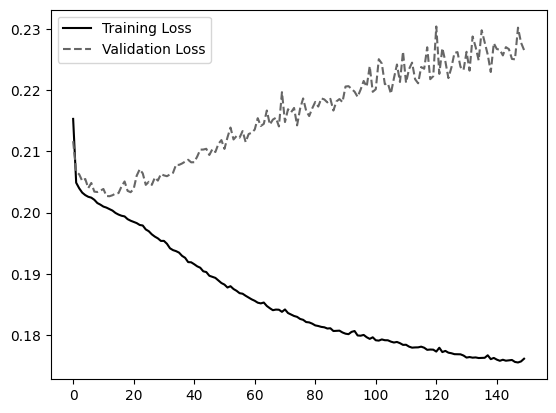

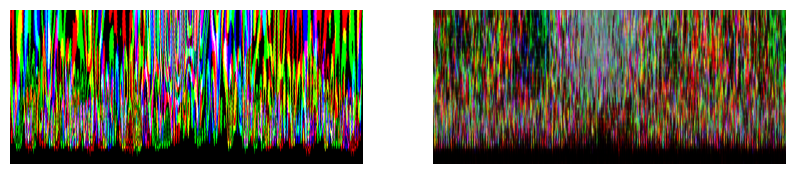

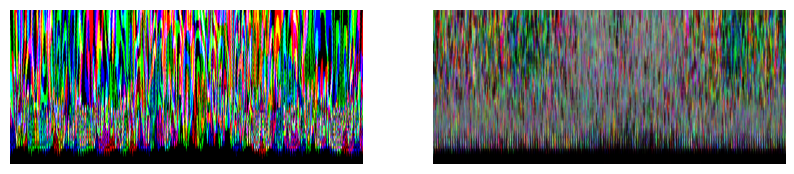

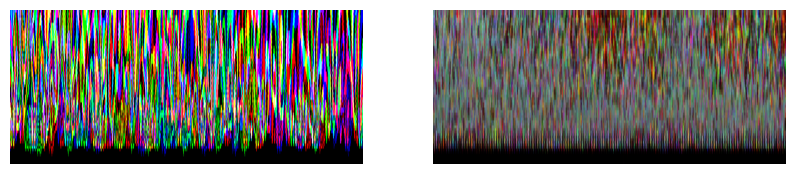

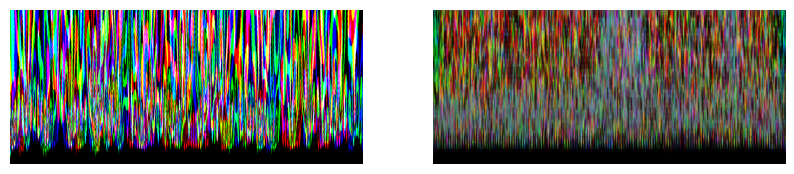

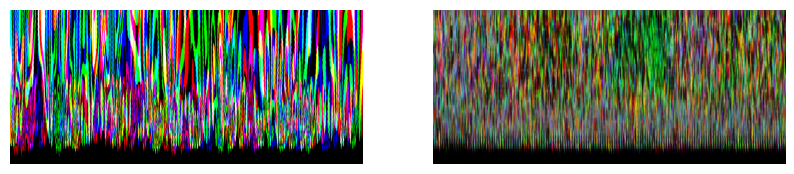

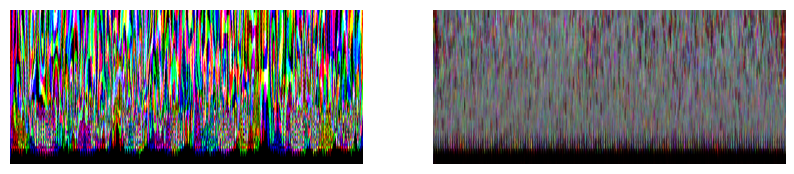

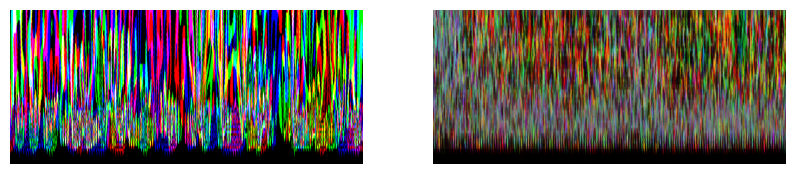

In [56]:
%matplotlib inline
for i in range(7):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,2), dpi=100 )
    ax1.imshow(teX[i*13], origin='lower',aspect='auto')
    ax1.axis("off")
    ax2.imshow(x_train_pred[i*13], origin='lower',aspect='auto')
    plt.axis("off")
    plt.show()

In [57]:
del trX, teX

In [58]:
del x_train_pred

In [66]:
toc = ti()

In [ ]:

if RunTwice:
    for j in range(int(len(files)/FilesPerRun)-1):
        Mats=[]
        AllDatas = Parallel(n_jobs=ConcurrentFiles)(delayed(runWrapper)(files[(i+j)*7], False, False, 0, ti()) for i in range(FilesPerRun))
        for fileResponse in AllDatas:
            for Mat in fileResponse:
                Mats.append(Mat)
        
        if MemoryProtection:
            del AllDatas
        
        lengths = []
        rejects = []
        Keeps = []
        
        for Mat in Mats:
            spm = np.shape(Mat)
            if len(spm) > 1:
                lenM = spm[1]
            else:
                lenM = 1
            if (lenM > 1250):
                lengths.append(lenM)
                Keeps.append(Mat)
            else:
                rejects.append(lenM)
        
        if MemoryProtection:
            print('RAM memory % used:', psutil.virtual_memory()[2])
            del Mats
        
        Prints = []
        
        
        AllPrints = Parallel(n_jobs=8)(delayed(PrintWrap)(Mat) for Mat in Keeps)
        
        if MemoryProtection:
            print('RAM memory % used:', psutil.virtual_memory()[2])
            del Keeps
        
        for group in AllPrints:
            for fprint in group:
                Prints.append(fprint)
        
        if MemoryProtection:
            print('RAM memory % used:', psutil.virtual_memory()[2])
            del AllPrints
        
        
        random.shuffle(Prints)
        
        TestLength = int(len(Prints)/TestSplit)
        
        for i, image in enumerate(Prints):
            if not isinstance(image, np.ndarray):
                Prints[i] = np.array(image, dtype=np.float32)
            elif image.dtype != np.float32:
                Prints[i] = image.astype(np.float32)
        
        # Stack the images into a single NumPy array
        prints_array = np.stack(Prints, axis=0)
        
        if MemoryProtection:
            del Prints
            print('RAM memory % used:', psutil.virtual_memory()[2])
        
        # Convert the NumPy array to a TensorFlow tensor
        tensor_prints = tf.convert_to_tensor(prints_array)
        
        if MemoryProtection:
            del prints_array
            print('RAM memory % used:', psutil.virtual_memory()[2])
        
        ImageShape = np.shape(tensor_prints)
        
        trX = tensor_prints[:TestLength]  #tf.convert_to_tensor(trainX, dtype=tf.float32)
        
        teX = tensor_prints[TestLength:]  #tf.convert_to_tensor(testX, dtype=tf.float32)
        
        if MemoryProtection:
            del tensor_prints
        
        checkpoint_callback = CustomModelCheckpoint(
            filepath='/scratch/models/3DFP_0927_'+str(j)+'_{epoch:02d}.keras',
            save_freq=3  
        )
        
        H = autoencoder.fit(
        	trX, trX,
        	validation_data=(teX, teX),
        	epochs=20,
            callbacks=[checkpoint_callback, es_callback],     
        	batch_size=BS*2)
        
        plt.plot(H.history["loss"], label="Training Loss")
        plt.plot(H.history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.show()
        
        x_train_pred = autoencoder.predict(teX[:1000])
        
        
        for i in range(7):
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12,2), dpi=200 )
            ax1.imshow(teX[i*13], origin='lower',aspect='auto')
            ax1.axis("off")
            ax2.imshow(x_train_pred[i*13], origin='lower',aspect='auto')
            ax2.axis("off")
            ax3.imshow(np.abs(teX[i*13]-x_train_pred[i*13]), origin='lower',aspect='auto')
            ax3.axis("off")
            plt.show()
        print(j, int((ti()-toc)/.6)*100)